# Local and Global Optimizers

We'll first set up our problem before exploring each optimizer class. We will start with a circuit containing eight variational parameters:

<div style="text-align: center;">
    <img src="../../QuantumOpt/image_QVC/optimization-circuit.svg" alt="optimization-circuit.svg" style="width: auto; height: auto;">
    <p style="font-size: 16px; font-style: italic; color: gray; margin-top: 5px;">
        High level overview of optimization loops.
    </p>
</div>

## References 

[1]. [Optimization loops (IBM)](https://quantum.cloud.ibm.com/learning/en/courses/variational-algorithm-design/optimization-loops)

C:\Users\berli\AppData\Local\Temp\ipykernel_61748\4169496569.py:12: DeprecationWarning: The class ``qiskit.circuit.library.n_local.two_local.TwoLocal`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.n_local instead.
  variational_form = TwoLocal(


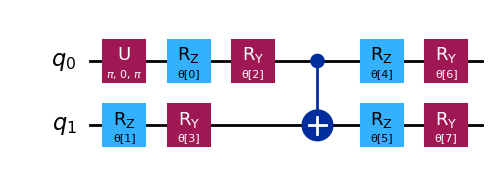

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np
 
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])
 
reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)
 
variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)
 
ansatz.decompose().draw("mpl")

In [3]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator
 
    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance
 
    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

In [4]:
from qiskit.primitives import StatevectorEstimator
 
estimator = StatevectorEstimator()

## Local optimizers

Local optimizers search for a point that minimizes the cost function starting at an initial point(s) $C(\vec{\theta_{0}})$ and move to different points based on what they observe in the region they are currently evaluating on successive iterations. This implies that the convergence of these algorithms will usually be fast, but can be heavily dependent on the initial point. Local optimizers are unable to see beyond the region where they are evaluating and can be especially vulnerable to local minima, reporting convergence when they find one and ignoring other states with more favorable evaluations.

In [5]:
# SciPy minimizer routine
from scipy.optimize import minimize
 
x0 = np.ones(8)
 
result = minimize(
    cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP"
)
 
result

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: -3.9999999964553954
           x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.556e-05 -1.207e+00
               -1.935e+00  4.079e-01 -4.079e-01]
         nit: 12
         jac: [-1.192e-07 -8.941e-08 -7.958e-04  2.543e-04  1.381e-03
                1.381e-03  5.430e-04  5.431e-04]
        nfev: 112
        njev: 12
 multipliers: []

## Gradient-based optimization

In [6]:
# SciPy minimizer routine
from scipy.optimize import minimize
 
x0 = np.ones(8)
 
result = minimize(
    cost_func_vqe, x0, args=(ansatz, observable, estimator), method="BFGS"
)
 
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.999999999999782
        x: [ 1.000e+00  1.000e+00  1.571e+00  2.785e-07  2.009e-01
            -2.009e-01  6.342e-01 -6.342e-01]
      nit: 14
      jac: [ 5.960e-08 -2.980e-08  8.941e-07  1.013e-06  2.086e-07
             1.490e-07  5.960e-08  5.960e-08]
 hess_inv: [[ 1.000e+00 -2.999e-08 ... -7.780e-05 -6.011e-05]
            [-2.999e-08  1.000e+00 ... -3.475e-06 -7.574e-07]
            ...
            [-7.780e-05 -3.475e-06 ...  7.242e-01 -2.603e-01]
            [-6.011e-05 -7.574e-07 ... -2.603e-01  8.180e-01]]
     nfev: 144
     njev: 16

## Gradient-free optimization 

-   Can find global optimum point. 
-   Need more copmutational resources then gradient-based algorithm

In [7]:
# SciPy minimizer routine
from scipy.optimize import minimize
 
x0 = np.ones(8)
 
result = minimize(
    cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA"
)
 
result

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -3.9999999973963356
       x: [ 6.150e-01  9.402e-01  1.571e+00  3.142e+00  2.364e+00
           -7.776e-01  2.061e+00  1.081e+00]
    nfev: 114
   maxcv: 0.0

## Barren Plateaus

Regardless of the type of optimization method used, if the cost landscape is relatively flat, it can be challenging for the method to determine the appropriate direction to search. This scenario is referred to as a barren plateau, where the cost landscape becomes progressively flatter (and thus more challenging to determine the direction to the minimum). 

For a broad range of parameterized quantum circuits, the probability that the gradient along any reasonable direction is non-zero to some fixed precision decreases exponentially as the number of qubits increases.

While this area is still under active research, we have a few recommendations to improve optimization performance:

*   Bootstrapping can help the optimization loop avoid getting stuck in a parameter space where the gradient is small.
*   Experimenting with hardware-efficient ansatz: Since we're using a noisy quantum system as a black-box oracle, the quality of those evaluations can affect the optimizer's performance. Using hardware-efficient ansatz, such as `EfficientSU2`, may avoid producing exponentially small gradients.
*   Experimenting with error suppression and error mitigation: the Qiskit Runtime primitives provide a simple interface to experiment with various values for optimization_level and resilience_setting, respectively. This can reduce the impact of noise and make the optimization process more efficient.
*   Experimenting with gradient-free optimizers: Unlike gradient-based optimization algorithms, optimizers such as COBYLA do not rely on gradient information to optimize the parameters and are therefore less likely to be affected by the barren plateau.
